In [ ]:
## Importing Libraries:

In [1]:
# !pip install pycountry_convert 
# !pip install folium
# !pip install calmap

## Libraries:

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
import folium
import branca
import plotly.express as px
import json, requests
import calmap


from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
from datetime import datetime,timedelta,date
from scipy.interpolate import make_interp_spline, BSpline

# plotly 
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "seaborn"

# setup
pd.set_option('max_columns', 50)

%matplotlib inline

In [2]:
# # models
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

## Data Retrieval

In [3]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [4]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  ...  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  5/14/20  5/15/20  \
0        0  ...    4033     4402     4687     4963     5226     5639     6053   
1        0  ...     856      868      872      876      880      898      916   
2        0  ...    5558     5723     5891     6067     6253     6442     6629   
3        0  ...     754      755      755      758      760      761      761   
4        0  ...      43       45       45       45       45       48       48   

   5/16/20  5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  \
0     6402     6664     7072     7653     8145     8676     9216     9998   
1      933      946      948      949      964      969      981      989   
2     6821     7019     7201     7377     7542     7728     7918     8113   
3      761      761      761      761      762      762      762      762   
4       48       48       50       52       52       58       60       61   

   5/24/20  5/25/20  5/26/20  5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  \
0    10582    11173    11831    12456    13036    13659    14525    15205   
1      998     1004     1029     1050     1076     1099     1122     1137   
2     8306     8503     8697     8857     8997     9134     9267     9394   
3      762      763      763      763      763      764      764      764   
4       69       70       70       71       74       81       84       86   

   6/1/20  6/2/20  
0   15750   16509  
1    1143    1164  
2    9513    9626  
3     765     844  
4      86      86  

[5 rows x 137 columns]

In [5]:
df_confirmed.isna().sum()

Province/State    185
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
5/29/20             0
5/30/20             0
5/31/20             0
6/1/20              0
6/2/20              0
Length: 137, dtype: int64

In [6]:
df_confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    21.148043   22.538640    2.086466    2.458647    3.537594    5.390977   
std     24.909990   70.466256   27.279200   27.377862   34.083035   47.434934   
min    -51.796300 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.907750  -18.093125    0.000000    0.000000    0.000000    0.000000   
50%     23.488100   20.972650    0.000000    0.000000    0.000000    0.000000   
75%     41.143200   77.191525    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20      1/30/20  \
count   266.000000   266.000000   266.000000   266.000000   266.000000   
mean      7.962406    11.003759    20.969925    23.180451    30.954887   
std      66.289178    89.313757   219.187744   220.524977   303.897894   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  4903.000000   

           1/31/20       2/1/20        2/2/20        2/3/20        2/4/20  \
count   266.000000   266.000000    266.000000    266.000000    266.000000   
mean     37.319549    45.255639     63.109023     74.740602     89.819549   
std     360.297287   443.366813    689.035590    832.955314   1026.584113   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.000000     0.000000      0.000000      0.000000      0.000000   
75%       0.000000     0.000000      0.000000      0.000000      0.000000   
max    5806.000000  7153.000000  11177.000000  13522.000000  16678.000000   

             2/5/20        2/6/20        2/7/20        2/8/20        2/9/20  \
count    266.000000    266.000000    266.000000    266.000000    266.000000   
mean     103.890977    115.766917    129.289474    139.548872    150.939850   
std     1209.757050   1359.930297   1534.124062   1665.834681   1820.908541   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    19665.000000  22112.000000  24953.000000  27100.000000  29631.000000   

            2/10/20       2/11/20       2/12/20       2/13/20  ...  \
count    266.000000    266.000000    266.000000    266.000000  ...   
mean     160.759398    168.428571    170.003759    226.947368  ...   
std     1949.404601   2049.811698   2050.151419   2958.037971  ...   
min        0.000000      0.000000      0.000000      0.000000  ...   
25%        0.000000      0.000000      0.000000      0.000000  ...   
50%        0.000000      0.000000      0.000000      0.000000  ...   
75%        0.000000      0.000000      0.000000      0.000000  ...   
max    31728.000000  33366.000000  33366.000000  48206.000000  ...   

             5/9/20       5/10/20       5/11/20       5/12/20       5/13/20  \
count  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02  2.660000e+02   
mean   1.512785e+04  1.541992e+04  1.570489e+04  1.602161e+04  1.634217e+04   
std    8.652542e+04  8.785657e+04  8.915518e+04  9.061438e+04  9.206191e+04   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    1.077500e+02  1.077500e+02  1.107500e+02  1.137500e+02  1.137500e+02   
50%    6.190000e+02  6.200000e+02  6.330000e+02  6.400000e+02  6.450000e+02   
75%    3.040750e+03  3.0420

In [7]:
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [8]:
df_deaths.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  ...  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  5/14/20  5/15/20  \
0        0  ...     115      120      122      127      132      136      153   
1        0  ...      31       31       31       31       31       31       31   
2        0  ...     494      502      507      515      522      529      536   
3        0  ...      48       48       48       48       49       49       49   
4        0  ...       2        2        2        2        2        2        2   

   5/16/20  5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  \
0      168      169      173      178      187      193      205      216   
1       31       31       31       31       31       31       31       31   
2      542      548      555      561      568      575      582      592   
3       51       51       51       51       51       51       51       51   
4        2        2        3        3        3        3        3        4   

   5/24/20  5/25/20  5/26/20  5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  \
0      218      219      220      227      235      246      249      257   
1       32       32       33       33       33       33       33       33   
2      600      609      617      623      630      638      646      653   
3       51       51       51       51       51       51       51       51   
4        4        4        4        4        4        4        4        4   

   6/1/20  6/2/20  
0     265     270  
1      33      33  
2     661     667  
3      51      51  
4       4       4  

[5 rows x 137 columns]

In [9]:
df_deaths.shape

(266, 137)

In [10]:
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")

In [11]:
df_covid19.head()

Country_Region          Last_Update      Lat     Long_  Confirmed  Deaths  \
0      Australia  2020-06-03 12:33:05 -25.0000  133.0000     7229.0   102.0   
1        Austria  2020-06-03 12:33:05  47.5162   14.5501    16759.0   669.0   
2         Canada  2020-06-03 12:33:05  60.0010  -95.0010    93960.0  7477.0   
3          China  2020-06-03 12:33:05  30.5928  114.3055    84159.0  4638.0   
4        Denmark  2020-06-03 12:33:05  56.2639    9.5018    11971.0   580.0   

   Recovered   Active  Incident_Rate  People_Tested  People_Hospitalized  \
0     6640.0    487.0      28.393893            NaN                  NaN   
1    15629.0    461.0     186.078788            NaN                  NaN   
2    50725.0  35758.0     248.205673            NaN                  NaN   
3    79399.0    122.0       5.991345            NaN                  NaN   
4    10750.0    641.0     206.674386            NaN                  NaN   

   Mortality_Rate  UID ISO3  
0        1.410984   36  AUS  
1        3.991885   40  AUT  
2        7.957642  124  CAN  
3        5.510997  156  CHN  
4        4.845042  208  DNK

In [12]:
df_covid19.isna().sum()

Country_Region           0
Last_Update              0
Lat                      2
Long_                    2
Confirmed                0
Deaths                   0
Recovered                0
Active                   0
Incident_Rate            2
People_Tested          188
People_Hospitalized    188
Mortality_Rate           0
UID                      0
ISO3                     2
dtype: int64

In [13]:
df_covid19.shape

(188, 14)

In [14]:
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head()

Country_Region          Last_Update      Lat     Long_  Confirmed  Deaths  \
0      Australia  2020-06-03 12:33:05 -25.0000  133.0000     7229.0   102.0   
1        Austria  2020-06-03 12:33:05  47.5162   14.5501    16759.0   669.0   
2         Canada  2020-06-03 12:33:05  60.0010  -95.0010    93960.0  7477.0   
3          China  2020-06-03 12:33:05  30.5928  114.3055    84159.0  4638.0   
4        Denmark  2020-06-03 12:33:05  56.2639    9.5018    11971.0   580.0   

   Recovered   Active  Incident_Rate  
0     6640.0    487.0      28.393893  
1    15629.0    461.0     186.078788  
2    50725.0  35758.0     248.205673  
3    79399.0    122.0       5.991345  
4    10750.0    641.0     206.674386

In [15]:
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [16]:
df_table.head()

Country_Region Last_Update  Confirmed  Deaths  Recovered  Active  \
0    Afghanistan  2020-01-22          0       0        NaN     NaN   
1    Afghanistan  2020-01-23          0       0        NaN     NaN   
2    Afghanistan  2020-01-24          0       0        NaN     NaN   
3    Afghanistan  2020-01-25          0       0        NaN     NaN   
4    Afghanistan  2020-01-26          0       0        NaN     NaN   

   Delta_Confirmed  Delta_Recovered  Incident_Rate  People_Tested  \
0              0.0              NaN            0.0            NaN   
1              0.0              NaN            0.0            NaN   
2              0.0              NaN            0.0            NaN   
3              0.0              NaN            0.0            NaN   
4              0.0              NaN            0.0            NaN   

   People_Hospitalized Province_State  FIPS  UID iso3 Report_Date_String  
0                  NaN            NaN   NaN    4  AFG         2020/01/22  
1                  NaN            NaN   NaN    4  AFG         2020/01/23  
2                  NaN            NaN   NaN    4  AFG         2020/01/24  
3                  NaN            NaN   NaN    4  AFG         2020/01/25  
4                  NaN            NaN   NaN    4  AFG         2020/01/26

In [17]:
df_table.isna().sum()

Country_Region             0
Last_Update                0
Confirmed                  0
Deaths                     0
Recovered              32718
Active                 32718
Delta_Confirmed           54
Delta_Recovered        32718
Incident_Rate            532
People_Tested          32718
People_Hospitalized    32718
Province_State         25004
FIPS                   25004
UID                        0
iso3                     266
Report_Date_String         0
dtype: int64

In [18]:
df_table.shape

(32718, 16)

In [19]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})

In [20]:
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

 Changing the country names

In [21]:
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"

In [22]:
df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"

In [23]:
df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"

In [24]:
df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"

In [25]:
df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"

In [26]:
df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"

In [27]:
df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"

In [28]:
df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"

In [29]:
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])

In [30]:
# # Continent_code to Continent_names
# continents = {
#     'NA': 'North America',
#     'SA': 'South America', 
#     'AS': 'Asia',
#     'OC': 'Australia',
#     'AF': 'Africa',
#     'EU' : 'Europe',
#     'na' : 'Others'
# }

In [31]:
# # Defininng Function for getting continent code for country.
# def country_to_continent_code(country):
#     try:
#         return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
#     except :
#         return 'na'

In [32]:
# #Collecting Continent Information
# df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
# df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
# df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
# df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])

In [33]:
df_confirmed.head()

state      country      Lat     Long  1/22/20  1/23/20  1/24/20  1/25/20  \
0   NaN  Afghanistan  33.0000  65.0000        0        0        0        0   
1   NaN      Albania  41.1533  20.1683        0        0        0        0   
2   NaN      Algeria  28.0339   1.6596        0        0        0        0   
3   NaN      Andorra  42.5063   1.5218        0        0        0        0   
4   NaN       Angola -11.2027  17.8739        0        0        0        0   

   1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
0        0        0        0        0        0        0       0       0   
1        0        0        0        0        0        0       0       0   
2        0        0        0        0        0        0       0       0   
3        0        0        0        0        0        0       0       0   
4        0        0        0        0        0        0       0       0   

   2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
0       0       0       0       0       0       0       0        0        0   
1       0       0       0       0       0       0       0        0        0   
2       0       0       0       0       0       0       0        0        0   
3       0       0       0       0       0       0       0        0        0   
4       0       0       0       0       0       0       0        0        0   

   ...  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  5/14/20  5/15/20  5/16/20  \
0  ...    4033     4402     4687     4963     5226     5639     6053     6402   
1  ...     856      868      872      876      880      898      916      933   
2  ...    5558     5723     5891     6067     6253     6442     6629     6821   
3  ...     754      755      755      758      760      761      761      761   
4  ...      43       45       45       45       45       48       48       48   

   5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  5/24/20  \
0     6664     7072     7653     8145     8676     9216     9998    10582   
1      946      948      949      964      969      981      989      998   
2     7019     7201     7377     7542     7728     7918     8113     8306   
3      761      761      761      762      762      762      762      762   
4       48       50       52       52       58       60       61       69   

   5/25/20  5/26/20  5/27/20  5/28/20  5/29/20  5/30/20  5/31/20  6/1/20  \
0    11173    11831    12456    13036    13659    14525    15205   15750   
1     1004     1029     1050     1076     1099     1122     1137    1143   
2     8503     8697     8857     8997     9134     9267     9394    9513   
3      763      763      763      763      764      764      764     765   
4       70       70       71       74       81       84       86      86   

   6/2/20  
0   16509  
1    1164  
2    9626  
3     844  
4      86  

[5 rows x 137 columns]

In [34]:
# df_table = df_table[df_table["continent"] != "Others"]

In [35]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [36]:
from datetime import datetime

In [37]:
def _convert_date_str(df):
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]

In [38]:
_convert_date_str(df_confirmed)

In [39]:
_convert_date_str(df_deaths)

In [40]:
df_confirmed

state                country        Lat       Long  2020-01-22  \
0                    Afghanistan  33.000000  65.000000           0   
1                        Albania  41.153300  20.168300           0   
2                        Algeria  28.033900   1.659600           0   
3                        Andorra  42.506300   1.521800           0   
4                         Angola -11.202700  17.873900           0   
..    ...                    ...        ...        ...         ...   
261        Sao Tome and Principe   0.186360   6.613081           0   
262                        Yemen  15.552727  48.516388           0   
263                      Comoros -11.645500  43.333300           0   
264                   Tajikistan  38.861034  71.276093           0   
265                      Lesotho -29.609988  28.233608           0   

     2020-01-23  2020-01-24  2020-01-25  2020-01-26  2020-01-27  2020-01-28  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
261           0           0           0           0           0           0   
262           0           0           0           0           0           0   
263           0           0           0           0           0           0   
264           0           0           0           0           0           0   
265           0           0           0           0           0           0   

     2020-01-29  2020-01-30  2020-01-31  2020-02-01  2020-02-02  2020-02-03  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
261           0           0           0           0           0           0   
262           0           0           0           0           0           0   
263           0           0           0           0           0           0   
264           0           0           0           0           0           0   
265           0           0           0           0           0           0   

     2020-02-04  2020-02-05  2020-02-06  2020-02-07  2020-02-08  2020-02-09  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
261           0           0           0           0           0           0   
262           0           0           0           0           0           0   
263           0           0           0           0           0           0   
264           0           0           0           0           0           0   
265           0           0           0           0           0           0   

     2020-02-10  2020-02-11  ...  2020-05-09  2020-05-10  2020-05-11  \
0             0           0  ...        4033        4402        4687   
1             0           0  ...         856         868         872   
2             0           0  ...        5558        5723        5891   
3             0           0 

In [41]:
confirmed_melt_df = df_confirmed.melt(
    id_vars=['state', 'country', 'Lat', 'Long'], value_vars=df_confirmed.columns[5:], var_name='Date', value_name='ConfirmedCases')
deaths_melt_df = df_deaths.melt(
    id_vars=['state', 'country', 'Lat', 'Long'], value_vars=df_deaths.columns[5:], var_name='Date', value_name='Deaths')

In [42]:
train = confirmed_melt_df.merge(deaths_melt_df, on=['state', 'country', 'Lat', 'Long', 'Date'])

In [43]:
train

state                country        Lat       Long        Date  \
0                      Afghanistan  33.000000  65.000000  2020-01-23   
1                          Albania  41.153300  20.168300  2020-01-23   
2                          Algeria  28.033900   1.659600  2020-01-23   
3                          Andorra  42.506300   1.521800  2020-01-23   
4                           Angola -11.202700  17.873900  2020-01-23   
...     ...                    ...        ...        ...         ...   
35107        Sao Tome and Principe   0.186360   6.613081  2020-06-02   
35108                        Yemen  15.552727  48.516388  2020-06-02   
35109                      Comoros -11.645500  43.333300  2020-06-02   
35110                   Tajikistan  38.861034  71.276093  2020-06-02   
35111                      Lesotho -29.609988  28.233608  2020-06-02   

       ConfirmedCases  Deaths  
0                   0       0  
1                   0       0  
2                   0       0  
3                   0       0  
4                   0       0  
...               ...     ...  
35107             484      12  
35108             399      87  
35109             132       2  
35110            4100      47  
35111               2       0  

[35112 rows x 7 columns]

In [44]:
ww_df = train.groupby('Date')[['ConfirmedCases','Deaths']].sum().reset_index()

In [45]:
ww_df

Date  ConfirmedCases  Deaths
0    2020-01-23             654      18
1    2020-01-24             941      26
2    2020-01-25            1434      42
3    2020-01-26            2118      56
4    2020-01-27            2927      82
..          ...             ...     ...
127  2020-05-29         5930781  364998
128  2020-05-30         6059017  369126
129  2020-05-31         6166946  372035
130  2020-06-01         6265852  375543
131  2020-06-02         6378237  380249

[132 rows x 3 columns]

In [46]:
ww_df['new_case'] = ww_df['ConfirmedCases'] - ww_df['ConfirmedCases'].shift(1)
ww_df['growth_factor'] = ww_df['new_case'] / ww_df['new_case'].shift(1)
ww_df.tail()

Date  ConfirmedCases  Deaths  new_case  growth_factor
127  2020-05-29         5930781  364998  121835.0       1.039938
128  2020-05-30         6059017  369126  128236.0       1.052538
129  2020-05-31         6166946  372035  107929.0       0.841644
130  2020-06-01         6265852  375543   98906.0       0.916399
131  2020-06-02         6378237  380249  112385.0       1.136281

In [47]:
ww_melt_df = pd.melt(ww_df, id_vars=['Date'], value_vars=['ConfirmedCases', 'Deaths', 'new_case'])
ww_melt_df

Date        variable     value
0    2020-01-23  ConfirmedCases     654.0
1    2020-01-24  ConfirmedCases     941.0
2    2020-01-25  ConfirmedCases    1434.0
3    2020-01-26  ConfirmedCases    2118.0
4    2020-01-27  ConfirmedCases    2927.0
..          ...             ...       ...
391  2020-05-29        new_case  121835.0
392  2020-05-30        new_case  128236.0
393  2020-05-31        new_case  107929.0
394  2020-06-01        new_case   98906.0
395  2020-06-02        new_case  112385.0

[396 rows x 3 columns]

In [48]:
pio.templates.default = "seaborn"
fig = px.line(ww_melt_df, x="Date", y="value", color='variable',
              title="Worldwide Confirmed/Death Cases Over Time")
fig.show()

In [49]:
fig = px.line(ww_melt_df, x="Date", y="value", color='variable',
              title="Worldwide Confirmed/Death Cases Over Time (Log scale)",
             log_y=True)
fig.show()

In [50]:
# Mortality Rate:
ww_df['Mortality'] = ww_df['Deaths'] / ww_df['ConfirmedCases']

fig = px.line(ww_df, x="Date", y="Mortality", 
              title="Worldwide Mortality Rate Over Time")
fig.show()

In [51]:
#Growth Factor:
fig = px.line(ww_df, x="Date", y="growth_factor", 
              title="Worldwide Growth Factor Over Time")
fig.add_trace(go.Scatter(x=[ww_df['Date'].min(), ww_df['Date'].max()], y=[1., 1.], name='Growth factor=1.', line=dict(dash='dash', color=('rgb(255, 0, 0)'))))
fig.update_yaxes(range=[0., 5.])
fig.show()

In [52]:
country_df = train.groupby(['Date', 'country'])[['ConfirmedCases', 'Deaths']].sum().reset_index()
country_df.head()

Date      country  ConfirmedCases  Deaths
0  2020-01-23  Afghanistan               0       0
1  2020-01-23      Albania               0       0
2  2020-01-23      Algeria               0       0
3  2020-01-23      Andorra               0       0
4  2020-01-23       Angola               0       0

In [53]:
countries = country_df['country'].unique()

In [54]:
target_date = country_df['Date'].max()
target_date

'2020-06-02'

In [55]:
top_country_df = country_df.query('(Date == @target_date) & (ConfirmedCases > 1000)').sort_values('ConfirmedCases', ascending=False)
top_country_melt_df = pd.melt(top_country_df, id_vars='country', value_vars=['ConfirmedCases', 'Deaths'])
top_confirmed_melt = pd.melt(top_country_df, id_vars='country', value_vars=['ConfirmedCases'])
top_death_melt = pd.melt(top_country_df, id_vars='country', value_vars=['Deaths'])

In [56]:
top_country_melt_df.head(10)

country        variable    value
0             USA  ConfirmedCases  1831821
1          Brazil  ConfirmedCases   555383
2          Russia  ConfirmedCases   423186
3  United Kingdom  ConfirmedCases   279392
4           Spain  ConfirmedCases   239932
5           Italy  ConfirmedCases   233515
6           India  ConfirmedCases   207191
7          France  ConfirmedCases   188450
8         Germany  ConfirmedCases   183879
9            Peru  ConfirmedCases   170039

In [57]:
fig = px.bar(top_confirmed_melt.iloc[9::-1],
             x='value', y='country', color='variable', barmode='group',
             title=f'Top 10 Countries having most Confirmed Cases on {target_date}', text='value', height=500, orientation='h')
fig.show()

In [58]:
top_death_melt.sort_values('value',ascending = False,inplace = True)

In [59]:
fig = px.bar(top_death_melt.iloc[9::-1],
             x='value', y='country', color='variable', barmode='group',
             title=f'Top 10 Countries having the most number of  Deaths on {target_date}', text='value', height=500, orientation='h')
fig.show()

In [60]:
top30_countries = top_country_df.sort_values('ConfirmedCases', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='Date', y='ConfirmedCases', color='country',
              title=f'Confirmed Cases for top 30 country as of {target_date}')
fig.show()

In [61]:
top30_countries = top_country_df.sort_values('Deaths', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='Date', y='Deaths', color='country',
              title=f'Deaths for top 30 country as of {target_date}')
fig.show()

In [62]:
top_country_df = country_df.query('(Date == @target_date) & (ConfirmedCases > 100)')
top_country_df['mortality_rate'] = top_country_df['Deaths'] / top_country_df['ConfirmedCases']
top_country_df = top_country_df.sort_values('mortality_rate', ascending=False)

In [63]:
top_country_df['mortality_rate']

24813    0.218045
24644    0.162160
24689    0.153585
24712    0.143588
24806    0.141207
           ...   
24779    0.000670
24658    0.000000
24810    0.000000
24803    0.000000
24742    0.000000
Name: mortality_rate, Length: 161, dtype: float64

In [64]:
fig = px.bar(top_country_df[:10].iloc[::-1],
             x='mortality_rate', y='country',
             title=f'Mortality rate HIGH: top 10 countries on {target_date}', text='mortality_rate', height=500, orientation='h')
fig.show()

In [65]:
all_country_df = country_df.query('Date == @target_date')
all_country_df['confirmed_log1p'] = np.log10(all_country_df['ConfirmedCases'] + 1)
all_country_df['fatalities_log1p'] = np.log10(all_country_df['Deaths'] + 1)
all_country_df['mortality_rate'] = all_country_df['Deaths'] / all_country_df['ConfirmedCases']

In [66]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="confirmed_log1p", 
                    hover_name="country", hover_data=["ConfirmedCases", 'Deaths', 'mortality_rate'],
                    range_color=[all_country_df['confirmed_log1p'].min(), all_country_df['confirmed_log1p'].max()], 
                    color_continuous_scale="sunsetdark", 
                    title='Countries with Confirmed Cases')

# I'd like to update colorbar to show raw values, but this does not work somehow...
# Please let me know if you know how to do this!!
trace1 = list(fig.select_traces())[0]
trace1.colorbar = go.choropleth.ColorBar(
    tickvals=[0, 1, 2, 3, 4, 5],
    ticktext=['1', '10', '100', '1000','10000', '100000'])
fig.show()

In [67]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="fatalities_log1p", 
                    hover_name="country", range_color=[0, 5],
                    hover_data=['ConfirmedCases', 'Deaths', 'mortality_rate'],
                    color_continuous_scale="sunset", 
                    title='Countries with fatalities')
fig.show()


In [68]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="mortality_rate", 
                    hover_name="country", range_color=[0, 0.12], 
                    color_continuous_scale="hot", 
                    title='Countries with mortality rate')
fig.show()

In [69]:
pio.templates.default = "plotly_dark"
country_df['Date'] = country_df['Date'].apply(str)
country_df['confirmed_log1p'] = np.log1p(country_df['ConfirmedCases'])
country_df['fatalities_log1p'] = np.log1p(country_df['Deaths'])

fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="ConfirmedCases", size='ConfirmedCases', hover_name="country", 
                     hover_data=['ConfirmedCases', 'Deaths'],
                     range_color= [0, country_df['ConfirmedCases'].max()], 
                     projection="natural earth", animation_frame="Date", 
                     title='COVID-19: Confirmed cases spread Over Time', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

## India

In [70]:
df_india_test = pd.json_normalize(requests.get('https://api.rootnet.in/covid19-in/stats/testing/history').json()['data']).rename(columns = {"totalIndividualsTested":"c_individualtest","totalPositiveCases":"c_positive","totalSamplesTested":"c_tests"})

In [71]:
df_india_test.head()

day  c_tests  c_individualtest  c_positive  \
0  2020-03-12   6500.0            5900.0        78.0   
1  2020-03-18  13125.0           12235.0       150.0   
2  2020-03-19  14175.0           13285.0       182.0   
3  2020-03-20  15404.0           14514.0       236.0   
4  2020-03-21  16911.0           16021.0       315.0   

                                    source  
0       Press_Release_ICMR_13March2020.pdf  
1  ICMR_website_update_18March_6PM_IST.pdf  
2  ICMR_website_update_19March_6PM_IST.pdf  
3  ICMR_website_update_20March_6PM_IST.pdf  
4  ICMR_website_update_21March_6PM_IST.pdf

In [72]:
df_india_test["p2t_ratio"]= np.round(100*df_india_test["c_positive"]/df_india_test["c_tests"],2)
df_india_test["positive"] = df_india_test["c_positive"].diff()
df_india_test["tests"] = df_india_test["c_tests"].diff()
df_india_test["p2t_ratio"]= np.round(100*df_india_test["positive"]/df_india_test["tests"],2)
df_india_test = df_india_test[1:]

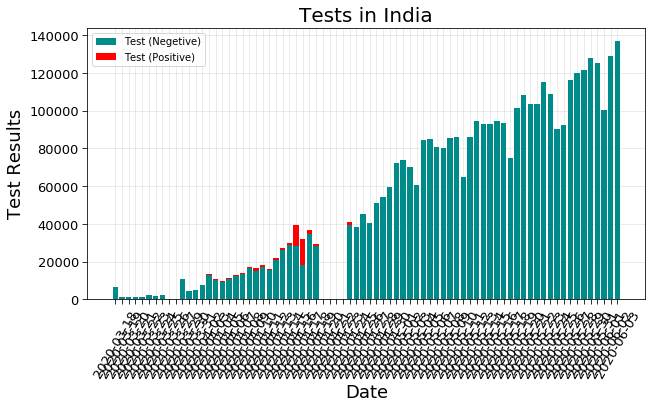

In [73]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.bar(df_india_test["day"],df_india_test["tests"].values[:],color="darkcyan",label="Test (Negetive)"+str())
plt.bar(df_india_test["day"],df_india_test["positive"].values[:],bottom=df_india_test["tests"].values[:]-df_india_test["positive"].values[:],color="Red",label="Test (Positive)")
plt.tick_params(size=5,labelsize = 13)
plt.tick_params(axis="x",size=5,labelsize = 13,labelrotation=60 )
plt.xlabel("Date",fontsize=18)
plt.ylabel("Test Results",fontsize=18)

plt.title("Tests in India",fontsize=20)
plt.grid(alpha=0.3)
plt.legend()

In [74]:
#Covid Cases in India 
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

In [75]:
df_india

confirmed  recovered  deaths  active
state                                                                         
Maharashtra                                   72300      31333    2465   38502
Tamil Nadu                                    24586      13706     200   10680
Delhi                                         22132       9243     556   12333
Gujarat                                       17632      11894    1092    4646
Rajasthan                                      9475       6506     203    2766
Madhya Pradesh                                 8420       5221     364    2835
Uttar Pradesh                                  8729       5176     229    3324
West Bengal                                    6168       2410     335    3423
State Unassigned                               7123          0       0    7123
Bihar                                          4273       1803      24    2446
Andhra Pradesh                                 3971       2464      68    1439
Karnataka                                      3796       1403      52    2339
Telangana                                      2891       1526      92    1273
Jammu and Kashmir                              2718        953      33    1732
Haryana                                        2652       1069      23    1560
Punjab                                         2342       2017      46     279
Odisha                                         2388       1416       9     963
Assam                                          1673        405       4    1261
Kerala                                         1495        651      12     832
Uttarakhand                                    1066        259       8     795
Jharkhand                                       726        296       5     425
Chhattisgarh                                    564        130       1     433
Himachal Pradesh                                345        136       6     200
Tripura                                         520        173       0     347
Chandigarh                                      301        214       5      82
Manipur                                          89         14       0      75
Ladakh                                           90         48       1      41
Goa                                              79         57       0      22
Puducherry                                       88         30       0      58
Nagaland                                         58          0       0      58
Andaman and Nicobar Islands                      33         33       0       0
Meghalaya                                        31         13       1      17
Arunachal Pradesh                                28          1       0      27
Dadra and Nagar Haveli and Daman and Diu          4          1       0       3
Mizoram                                          13          1       0      12
Sikkim                                            1          0       0       1
Lakshadweep                                       0          0       0       0

In [76]:
total = df_india.sum()
total.name = "Total"
df_t = pd.DataFrame(total,dtype=float).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["deaths"]/df_t["confirmed"],2)
df_t.style.background_gradient(cmap='Purples',axis=1)

In [77]:
pio.templates.default = "seaborn"
fig = px.bar(df_india[:10].iloc[::-1],
             x='confirmed', y=df_india.index[:10][::-1],
             title=f'States having the most number of Confirmed Cases', text='confirmed', height=500, orientation='h')
fig.show()

In [78]:
deaths_sort = df_india.sort_values('deaths',ascending= False)

In [79]:
fig = px.bar(deaths_sort[:10].iloc[::-1],
             x='deaths', y=deaths_sort.index[:10][::-1],
             title=f'States having the most number of Deaths', text='deaths', height=500, orientation='h')
fig.show()

In [80]:
active_sort = df_india.sort_values('active',ascending= False)

In [81]:
fig = px.bar(active_sort[:10].iloc[::-1],
             x='active', y=deaths_sort.index[:10][::-1],
             title=f'Top 10 States having the most number of Active Cases', text='active', height=500, orientation='h')
fig.show()

In [82]:
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""

for index in df_india.index :
    if index in locations:
        df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
        df_india.loc[df_india.index == index,"Long"] = locations[index][1]
    else:
        df_india.drop([index],inplace=True)

In [83]:
df_india['states'] = df_india.index

In [84]:
fig = px.scatter_mapbox(df_india, lat="Lat", lon="Long", hover_name="states", hover_data=["states", "confirmed",'recovered','deaths','active'],
                        color="confirmed", size=df_india["confirmed"],size_max=15, zoom=3, height=500)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.add_trace(go.Scattermapbox(
        lat=df_india['Lat'],
        lon=df_india['Long'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=35,
            color=df_india['confirmed'],
            colorscale = 'Viridis',
            opacity=0.7
        ),
        hoverinfo='none'
    ))
fig.show()